In [187]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log
from matplotlib import pyplot
import csv

In [119]:
def gen_data(num_pos: int,
             num_neg: int,):
    
    
    mean_pos = np.asarray(([[4], [4]]))
    sigma_pos = np.asarray([[500,50],[50,1]])
    mean_neg = np.asarray(([[-3], [-3]]))
    sigma_neg = np.asarray([[500,50],[50,1]])
    
    # Dimension of the feature vectors
    num_features = sigma_pos.shape[0]

    # Initialize the features and labels
    features = np.zeros(shape=(num_pos + num_neg, num_features))
    labels = np.zeros(shape=(num_pos + num_neg, 1))
    
    
    positiveFeature = np.random.multivariate_normal(np.asarray(mean_pos).flatten(),sigma_pos,num_pos)
    negativeFeature = np.random.multivariate_normal(np.asarray(mean_neg).flatten(),sigma_neg,num_neg)
    
    positiveLabel = np.ones((num_pos))
    negativeLabel = np.zeros((num_neg))
    
    features = np.concatenate((positiveFeature,negativeFeature),axis=0)
    labels = np.concatenate((positiveLabel,negativeLabel),axis=0)
    
    return features, labels


<ipython-input-119-9503f2aa535e>:18: RuntimeWarning: covariance is not positive-semidefinite.
  positiveFeature = np.random.multivariate_normal(np.asarray(mean_pos).flatten(),sigma_pos,num_pos)
<ipython-input-119-9503f2aa535e>:19: RuntimeWarning: covariance is not positive-semidefinite.
  negativeFeature = np.random.multivariate_normal(np.asarray(mean_neg).flatten(),sigma_neg,num_neg)


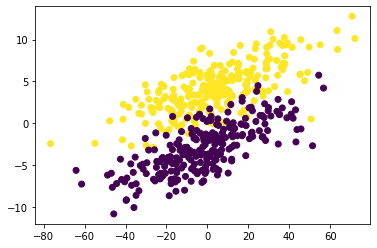

In [126]:
f,l = gen_data(250, 250)
plt.scatter(f[:,0],f[:,1],c=l,marker='o')
plt.show()

In [127]:
def LDA(X,y):
    #Calculating mean
    M1 = np.mean(X[y==0], axis=0)
    M2 = np.mean(X[y==1], axis=0)
    
    #Between class variance SB
    num = M2-M1
    SB = num[:, np.newaxis] @ num[np.newaxis, :]
    
    #Within class  variance SW
    sw1 = 0
    i1 = 0
    for col in X[y==0]:
        vec = col-M1
        sw1 =sw1 + vec[:, np.newaxis] @ vec[np.newaxis, :]
        i1=i1+1
    sw2 = 0
    i2=0
    for col in X[y==1]:
        vec = col-M2
        sw2 =sw2 + vec[:, np.newaxis] @ vec[np.newaxis, :]
        i2=i2+1
    SW = sw1/i1 + sw2/i2

    #Projection matrix W
    S = np.linalg.inv(SW) @ SB
    w,v = np.linalg.eig(S)

    #1D projection, selecting eigen vector corresponding to highest eigen value
    W = v[:,np.argmax(w)]
    
    X_LDA = X @ W[:, np.newaxis]
    
    return X_LDA

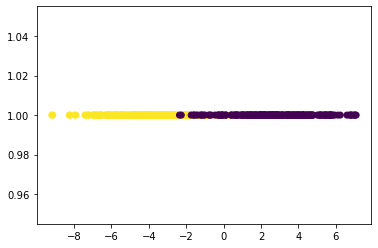

In [128]:
X = LDA(f,l)
plt.scatter(X,np.ones(500),c=l)

In [159]:
def Radial(x1, x2, gamma):
    diff = x1 - x2
    return np.exp(-np.dot(diff, diff) * gamma)

def Laplacian(x1, x2, gamma):
    diff = x1 - x2
    return np.exp(-np.abs(diff) * gamma)

def Sigmoid(x1, x2):
    return np.exp(np.dot(x1, x2))/(1+(np.exp(np.dot(x1, x2))))

def Linear(x1, x2):
    return np.dot(x1, x2)

def Polynomial(x1,x2, power):
    prod = np.dot(x1, x2)
    ans = (prod + 10*len(x1))**power
    if np.isscalar(ans):
        return ans
    else:
        return 0


def train_KFDA(X, y, hyperparameter,kernel="G"):
    
    # Computing Gram matrix
    if(kernel== "G"):
        K = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  Radial(x1, x2, hyperparameter), 1, X),1, X)
    if(kernel== "P"):   
        K = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  Polynomial(x1, x2, hyperparameter), 1, X),1, X)
    if(kernel== "L"):   
        K = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  Linear(x1, x2), 1, X),1, X)
    if(kernel== "La"):   
        K = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  Polynomial(x1, x2, hyperparameter), 1, X),1, X)
    if(kernel== "S"):   
        K = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  Linear(x1, x2), 1, X),1, X)


    # calculating indices of data points of two class
    index1 = []
    index2 = []
    for i in range(len(y)):
        if y[i] == 0:
            index1.append(i)
        else:
            index2.append(i)
    
    # calculating class based K1 and K2 for calculation of N (Within class scatter)
    K1 = []
    K2 = []
    for i in K:
        temp1 = []
        temp2 = []
        for j in index1:
            temp1.append(i[j])
        for j in index2:
            temp2.append(i[j])
        K1.append(np.array(temp1))
        K2.append(np.array(temp2))

    K1 = np.array(K1)
    K2 = np.array(K2)
    
    # calculating N(A = I - 1lj)
    
    A1 = np.identity(len(index1)) - ((1/float(len(index1))) * np.ones((len(index1), len(index1))))
    A2 = np.identity(len(index2)) - ((1/float(len(index2))) * np.ones((len(index2), len(index2))))
    
    N1 = np.dot(A1, K1.T)
    N1 = np.dot(K1, N1)

    N2 = np.dot(A2, K2.T)
    N2 = np.dot(K2, N2)

    N = N1 + N2

    # calculating N inverse
    N_inv = np.linalg.inv(N)

    # calculating M
    M1 = []
    M2 = []
    for i in range(len(K1)):
        M1.append(np.sum(K1[i])/float(len(index1)))
    for i in range(len(K2)):
        M2.append(np.sum(K2[i])/float(len(index2)))
    M1 = np.array(M1)
    M2 = np.array(M2)

    # calculating alpha
    M = M2 - M1
    alpha = np.dot(N_inv, M)

    # projecting data
    Y = []
    for i in K:
        temp = 0
        for j in range(len(i)):
            temp += alpha[j] * i[j]
        Y.append(temp)
    Y = np.array(Y)
    return Y, alpha

In [161]:
def test_KFDA(X, alpha, hyperparameter,kernel="G"):
    
    # Computing Gram matrix
    if(kernel== "G"):
        K = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  Radial(x1, x2, hyperparameter), 1, X),1, X)
    if(kernel== "P"):   
        K = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  Polynomial(x1, x2, hyperparameter), 1, X),1, X)
    if(kernel== "L"):   
        K = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  Linear(x1, x2), 1, X),1, X)
    if(kernel== "La"):   
        K = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  Polynomial(x1, x2, hyperparameter), 1, X),1, X)
    if(kernel== "S"):   
        K = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  Linear(x1, x2), 1, X),1, X)


    # projecting data
    Y = []
    for i in K:
        temp = 0
        for j in range(len(i)):
            temp += alpha[j] * i[j]
        Y.append(temp)
    return np.array(Y)

<ipython-input-119-9503f2aa535e>:18: RuntimeWarning: covariance is not positive-semidefinite.
  positiveFeature = np.random.multivariate_normal(np.asarray(mean_pos).flatten(),sigma_pos,num_pos)
<ipython-input-119-9503f2aa535e>:19: RuntimeWarning: covariance is not positive-semidefinite.
  negativeFeature = np.random.multivariate_normal(np.asarray(mean_neg).flatten(),sigma_neg,num_neg)


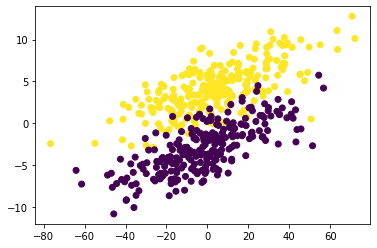

In [134]:
f_test,l_test = gen_data(50, 50)
plt.scatter(f[:,0],f[:,1],c=l,marker='o')
plt.show()

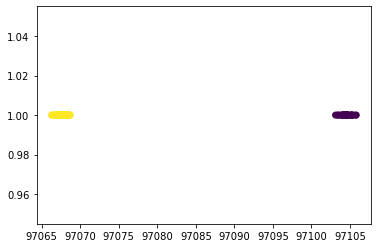

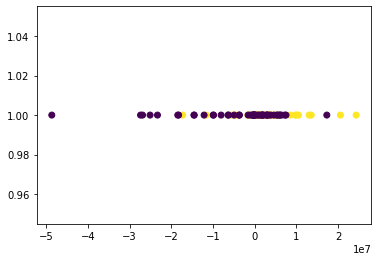

In [151]:
X_kfda, a = train_KFDA(f,l,kernel="G", hyperparameter=0.155)
plt.scatter(X_kfda,np.ones(500),c=l)
plt.show()
X_test = test_KFDA(f_test,a,kernel="G", hyperparameter=0.155)
plt.scatter(X_test,np.ones(100),c=l_test)

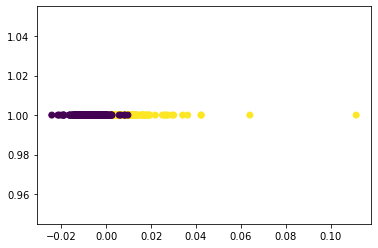

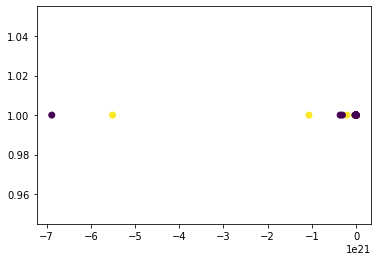

In [157]:
X_kfda, a = train_KFDA(f,l,kernel="P", hyperparameter=16)
plt.scatter(X_kfda,np.ones(500),c=l)
plt.show()
X_test = test_KFDA(f_test,a,kernel="P", hyperparameter=16)
plt.scatter(X_test,np.ones(100),c=l_test)

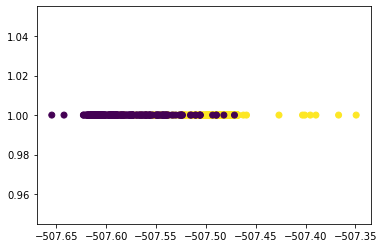

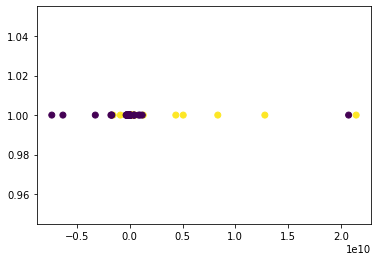

In [167]:
X_kfda, a = train_KFDA(f,l,kernel="La", hyperparameter=5)
plt.scatter(X_kfda,np.ones(500),c=l)
plt.show()
X_test = test_KFDA(f_test,a,kernel="La", hyperparameter=5)
plt.scatter(X_test,np.ones(100),c=l_test)

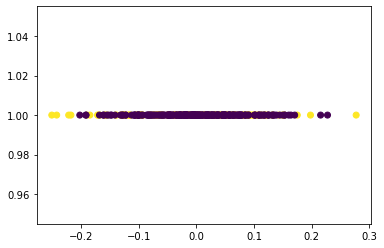

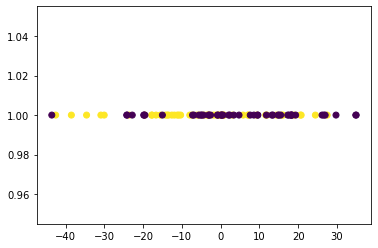

In [168]:
X_kfda, a = train_KFDA(f,l,kernel="S", hyperparameter=1)
plt.scatter(X_kfda,np.ones(500),c=l)
plt.show()
X_test = test_KFDA(f_test,a,kernel="S", hyperparameter=1)
plt.scatter(X_test,np.ones(100),c=l_test)

In [169]:
data=[]
with open('arcene_train.data', 'r') as csvfile:
    data_lines = csv.reader(csvfile, delimiter=' ')
    for item in data_lines:
        item = np.array(item[:-1])
        data.append(item.astype(float))
    csvfile.close()
label = []
with open('arcene_train_labels.csv', 'r') as labelfile:
    for i in labelfile:
        label.append((int(i)+1)/2)
data = np.asarray(data)
label = np.asarray(label)
label.shape

(100,)

In [170]:
datatest=[]
with open('arcene_test.data', 'r') as csvfile:
    data_lines = csv.reader(csvfile, delimiter=' ')
    for item in data_lines:
        item = np.array(item[:-1])
        datatest.append(item.astype(float))
    csvfile.close()
labeltest = []
with open('arcene_test_labels.csv', 'r') as labelfile:
    for i in labelfile:
        labeltest.append((int(i)+1)/2)
datatest = np.asarray(datatest)
labeltest = np.asarray(labeltest)
datatest.shape

(100, 10000)

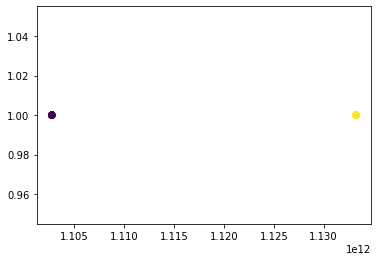

Linear FDA


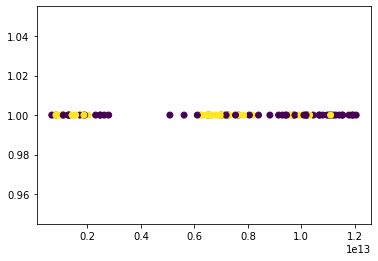

In [255]:
X_ar,a = train_KFDA(data,label,kernel="L", hyperparameter=14)
colors = {0:'red', 1:'black'}
plt.scatter(X_ar,np.ones(100),c=label)
plt.show()
print("Linear FDA")
Xt_ar = test_KFDA(datatest,a,kernel="L", hyperparameter=14)
plt.scatter(Xt_ar,np.ones(100),c=labeltest)

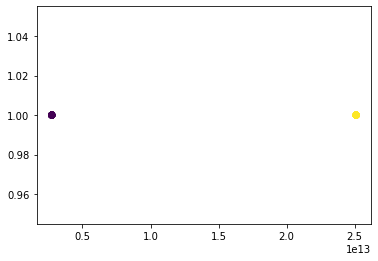

Polynomial kernel


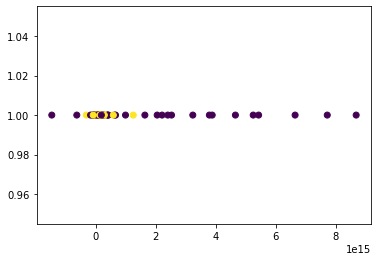

In [256]:
X_ar,a = train_KFDA(data,label,kernel="P", hyperparameter=14)
colors = {0:'red', 1:'black'}
plt.scatter(X_ar,np.ones(100),c=label)
plt.show()
print("Polynomial kernel")
Xt_ar = test_KFDA(datatest,a,kernel="P", hyperparameter=14)
plt.scatter(Xt_ar,np.ones(100),c=labeltest)

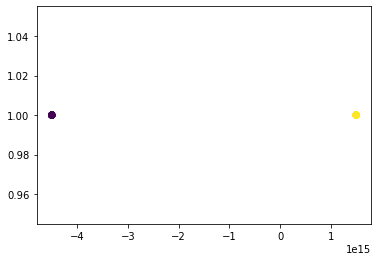

Gaussian Kernel


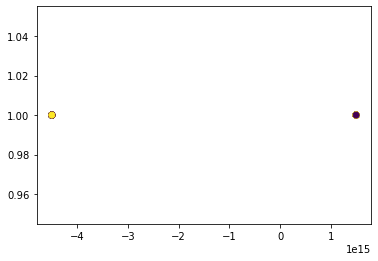

In [257]:
X_ar,a = train_KFDA(data,label,kernel="G", hyperparameter=1.5)
plt.scatter(X_ar,np.ones(100),c=label)
plt.show()
print("Gaussian Kernel")
Xt_ar = test_KFDA(datatest,a,kernel="G", hyperparameter=1.5)
plt.scatter(Xt_ar,np.ones(100),c=labeltest)

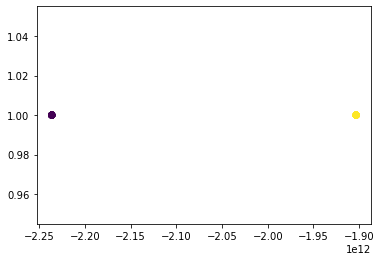

Laplacian Kernel


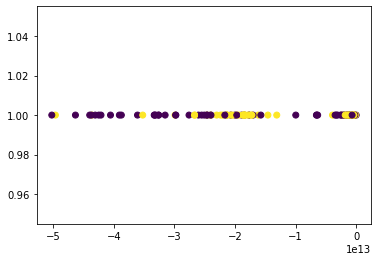

In [258]:
X_ar,a = train_KFDA(data,label,kernel="La", hyperparameter=3.7)
plt.scatter(X_ar,np.ones(100),c=label)
plt.show()
print("Laplacian Kernel")
Xt_ar = test_KFDA(datatest,a,kernel="La", hyperparameter=3.7)
plt.scatter(Xt_ar,np.ones(100),c=labeltest)

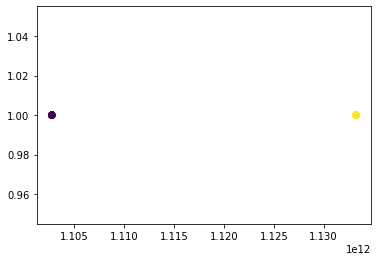

Sigmoid


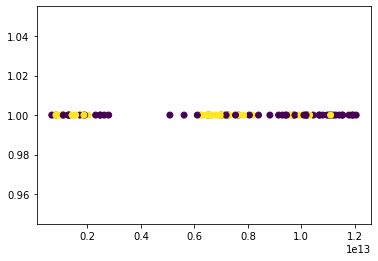

In [259]:
X_ar,a = train_KFDA(data,label,kernel="S", hyperparameter=3.7)
plt.scatter(X_ar,np.ones(100),c=label)
plt.show()
print("Sigmoid")
Xt_ar = test_KFDA(datatest,a,kernel="S", hyperparameter=3.7)
plt.scatter(Xt_ar,np.ones(100),c=labeltest)

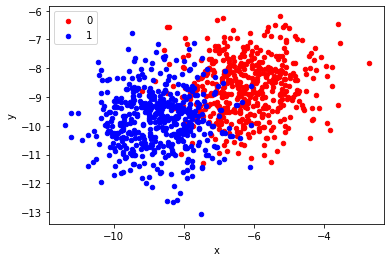

In [244]:
from sklearn.datasets import make_blobs
from pandas import DataFrame
Xblob, yblob = make_blobs(n_samples=1000, centers=2, random_state=673)

df = DataFrame(dict(x=Xblob[:,0], y=Xblob[:,1], label=yblob))
colors = {0:'red', 1:'blue', 2:'green', 3:'cyan', 4:'magenta'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

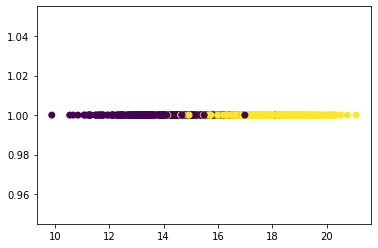

In [267]:
X_ar,a = train_KFDA(Xblob,yblob,kernel="S", hyperparameter=1)

plt.scatter(X_ar,np.ones(1000),c=yblob)

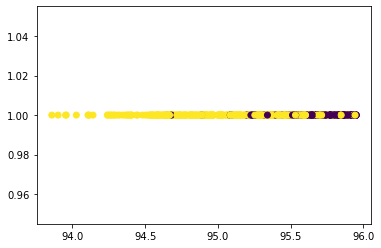

In [268]:
X_ar,a = train_KFDA(Xblob,yblob,kernel="G", hyperparameter=0.025)

plt.scatter(X_ar,np.ones(1000),c=yblob)

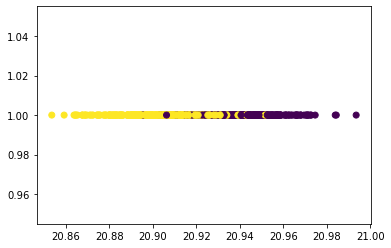

In [269]:
X_ar,a = train_KFDA(Xblob,yblob,kernel="P", hyperparameter=1.5)

plt.scatter(X_ar,np.ones(1000),c=yblob)

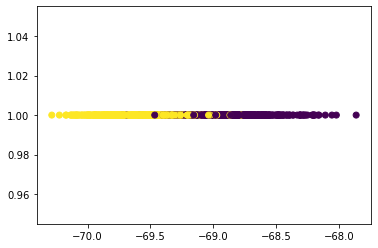

In [270]:
X_ar,a = train_KFDA(Xblob,yblob,kernel="La", hyperparameter=0.6)

plt.scatter(X_ar,np.ones(1000),c=yblob)

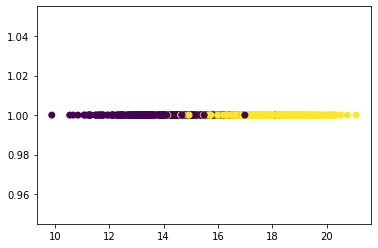

In [271]:
X_ar,a = train_KFDA(Xblob,yblob,kernel="L", hyperparameter=1)

plt.scatter(X_ar,np.ones(1000),c=yblob)